# Customer segmentation


At first, I upload all the necessary Python Liberaries to run the notebook.

In [ ]:
# For importing data
import kagglehub
import os

# Handling Data and visualizations
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path

# Models and other
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
from sentence_transformers import SentenceTransformer
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.patches as mpatches
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

## 1. Data & Basic cleaning

I load the data directly from Kaggle.

In [ ]:
# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")
path = os.path.join(path, "data.csv")

df_initial = pd.read_csv(path, encoding='latin-1')

Using Colab cache for faster access to the 'ecommerce-data' dataset.


It is important to review some of the most information about the dataset before moving into the cleaning part.

*a. Dataframe dimensions*

In [ ]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


*b. Review the existence of missing values, and data types*

In [ ]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


--> There's missing data in both **Description** and **CustomerID** columns

--> The data type of the date is not accurate

In [ ]:
# Format the date type
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

# Drop the duplicates
df_initial = df_initial.drop_duplicates()

# Missing values in both columns Description and CustomerID
df_without_nulls = df_initial[(pd.notna(df_initial['Description'])) & (pd.notna(df_initial['CustomerID']))]

print(f"The percentage of non-null columns is: {round((len(df_without_nulls)/len(df_initial))*100, 2)}%")

The percentage of non-null columns is: 74.84%


--> Meaning we can remove the missing values (I removed missing descriptions since I worked on this dataset before and it is better to remove them)

In [ ]:
df_initial = df_initial[(~pd.isna(df_initial['CustomerID'])) | (~pd.isna(df_initial['Description']))]
df_initial.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

___
## 2. Exploratory Analysis

 *a. Countries*

Here, I quickly look at the countries from which orders were made with a vizualisation.

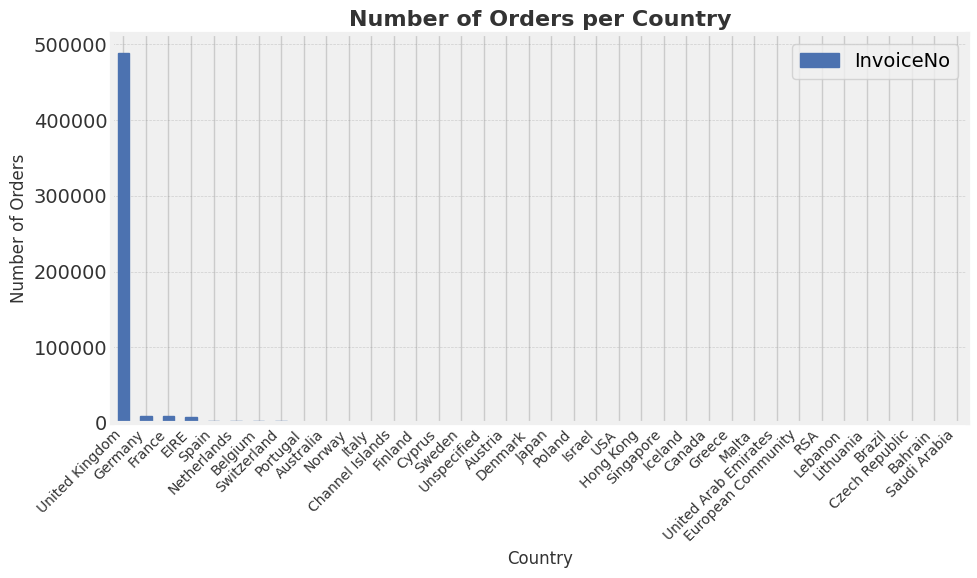

In [ ]:
df_nb_orders_country = df_initial[['InvoiceNo', 'Country']].groupby(by=['Country']).count().sort_values(by='InvoiceNo', ascending=False)

# ---- Visualize the number of orders per country ----
# Create the bar plot with enhanced styling
ax = df_nb_orders_country.plot(
    kind='bar',
    figsize=(10, 6),
    color='#4C72B0',   # soft modern blue
    edgecolor='#4C72B0',
)

# Improve layout and appearance
plt.title('Number of Orders per Country', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Country', fontsize=12, color='#333333')
plt.ylabel('Number of Orders', fontsize=12, color='#333333')
plt.xticks(rotation=45, ha='right', fontsize=10, color='#333333')
plt.yticks(color='#333333')

# Set white background and remove grid lines
plt.gcf().set_facecolor('white')
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

The sales are largely centered in UK.

___
*b. Customers and products*

The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

In [ ]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3958,24446,4372


It can be seen that the data concern 4372 users and that they bought 3958 different products. The total number of transactions carried out is of the order of $\sim$24'000.

Now I will determine the number of products purchased in every transaction:

In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order



___
*c. Canceled orders*

First of all, I count the number of transactions corresponding to canceled orders:

In [ ]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first lines of the dataframe:

In [ ]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
72253,542237,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,2011-01-26 14:30:00,3.75,12347.0,Iceland
148287,549222,22371,AIRLINE BAG VINTAGE TOKYO 78,4,2011-04-07 10:43:00,4.25,12347.0,Iceland
148286,549222,22374,AIRLINE BAG VINTAGE JET SET RED,4,2011-04-07 10:43:00,4.25,12347.0,Iceland


On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [ ]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID      14527.0
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [ ]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1])
                & (df_initial['Description'] == col[2])].shape[0] == 0:
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                             15311.0
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe that indicate if part of the order has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the purchases were took place before December 2010 (the point of entry of the database). Below, I count the canceled orders and check for the counterpart:

In [ ]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) &
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) &
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1):
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In the above function, I checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `doubtfull_entry` and `entry_to_remove` lists whose sizes are:

In [ ]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtfull_entry: {}".format(len(doubtfull_entry)))

entry_to_remove: 7521
doubtfull_entry: 2079


Among these entries, the lines listed in the * doubtfull_entry * list correspond to the entries indicating a cancellation but for which there is no order beforehand. In practice, I decide to delete all of these entries, which count respectively for  $\sim$1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [ ]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358.0,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422.0,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754.0,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [ ]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048.0,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048.0,United Kingdom,0


We see that the quantity canceled is greater than the sum of the previous purchases.


___
*d. StockCode*


Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for _Discount_). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [ ]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE',
       'DCGS0076', 'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm',
       'gift_0001_50', 'gift_0001_30', 'gift_0001_20', 'DCGS0069',
       'DCGSSBOY', 'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004',
       'B'], dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
DOT             -> DOTCOM POSTAGE                
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
AMAZONFEE       -> AMAZON FEE                    
DCGS0076        -> SUNJAR LED NIGHT NIGHT LIGHT  
DCGS0003        -> BOXED GLASS ASHTRAY           
gift_0001_40    -> Dotcomgiftshop Gift Voucher £40.00
DCGS0070        -> CAMOUFLAGE DOG COLLAR         
m               -> Manual                        
gift_0001_50    -> Dotcomgiftshop Gift Voucher £50.00
gift_0001_30    -> Dotcomgiftshop Gift Voucher £30.00
gift_0001_20    -> Dotcomgiftshop Gift Voucher £20.00
DCGS0069        -> OOH LA LA DOGS COLLAR         
DCGSSBOY        -> BOYS PARTY BAG                
DCGSSGIRL       -> GIRLS PARTY BAG               
gift_0001_10    -> Dotcomgiftshop Gift Voucher £10.00
S               -> SAMPLES    

We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges.


___
*e. Basket Price*

I create a new variable that indicates the total price of every purchase:

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
72266,542237,21035,SET/2 RED RETROSPOT TEA TOWELS,6,2011-01-26 14:30:00,2.95,12347.0,Iceland,0,17.7
72274,542237,84558A,3D DOG PICTURE PLAYING CARDS,12,2011-01-26 14:30:00,2.95,12347.0,Iceland,0,35.4
72273,542237,21731,RED TOADSTOOL LED NIGHT LIGHT,12,2011-01-26 14:30:00,1.65,12347.0,Iceland,0,19.8
72249,542237,20719,WOODLAND CHARLOTTE BAG,10,2011-01-26 14:30:00,0.85,12347.0,Iceland,0,8.5


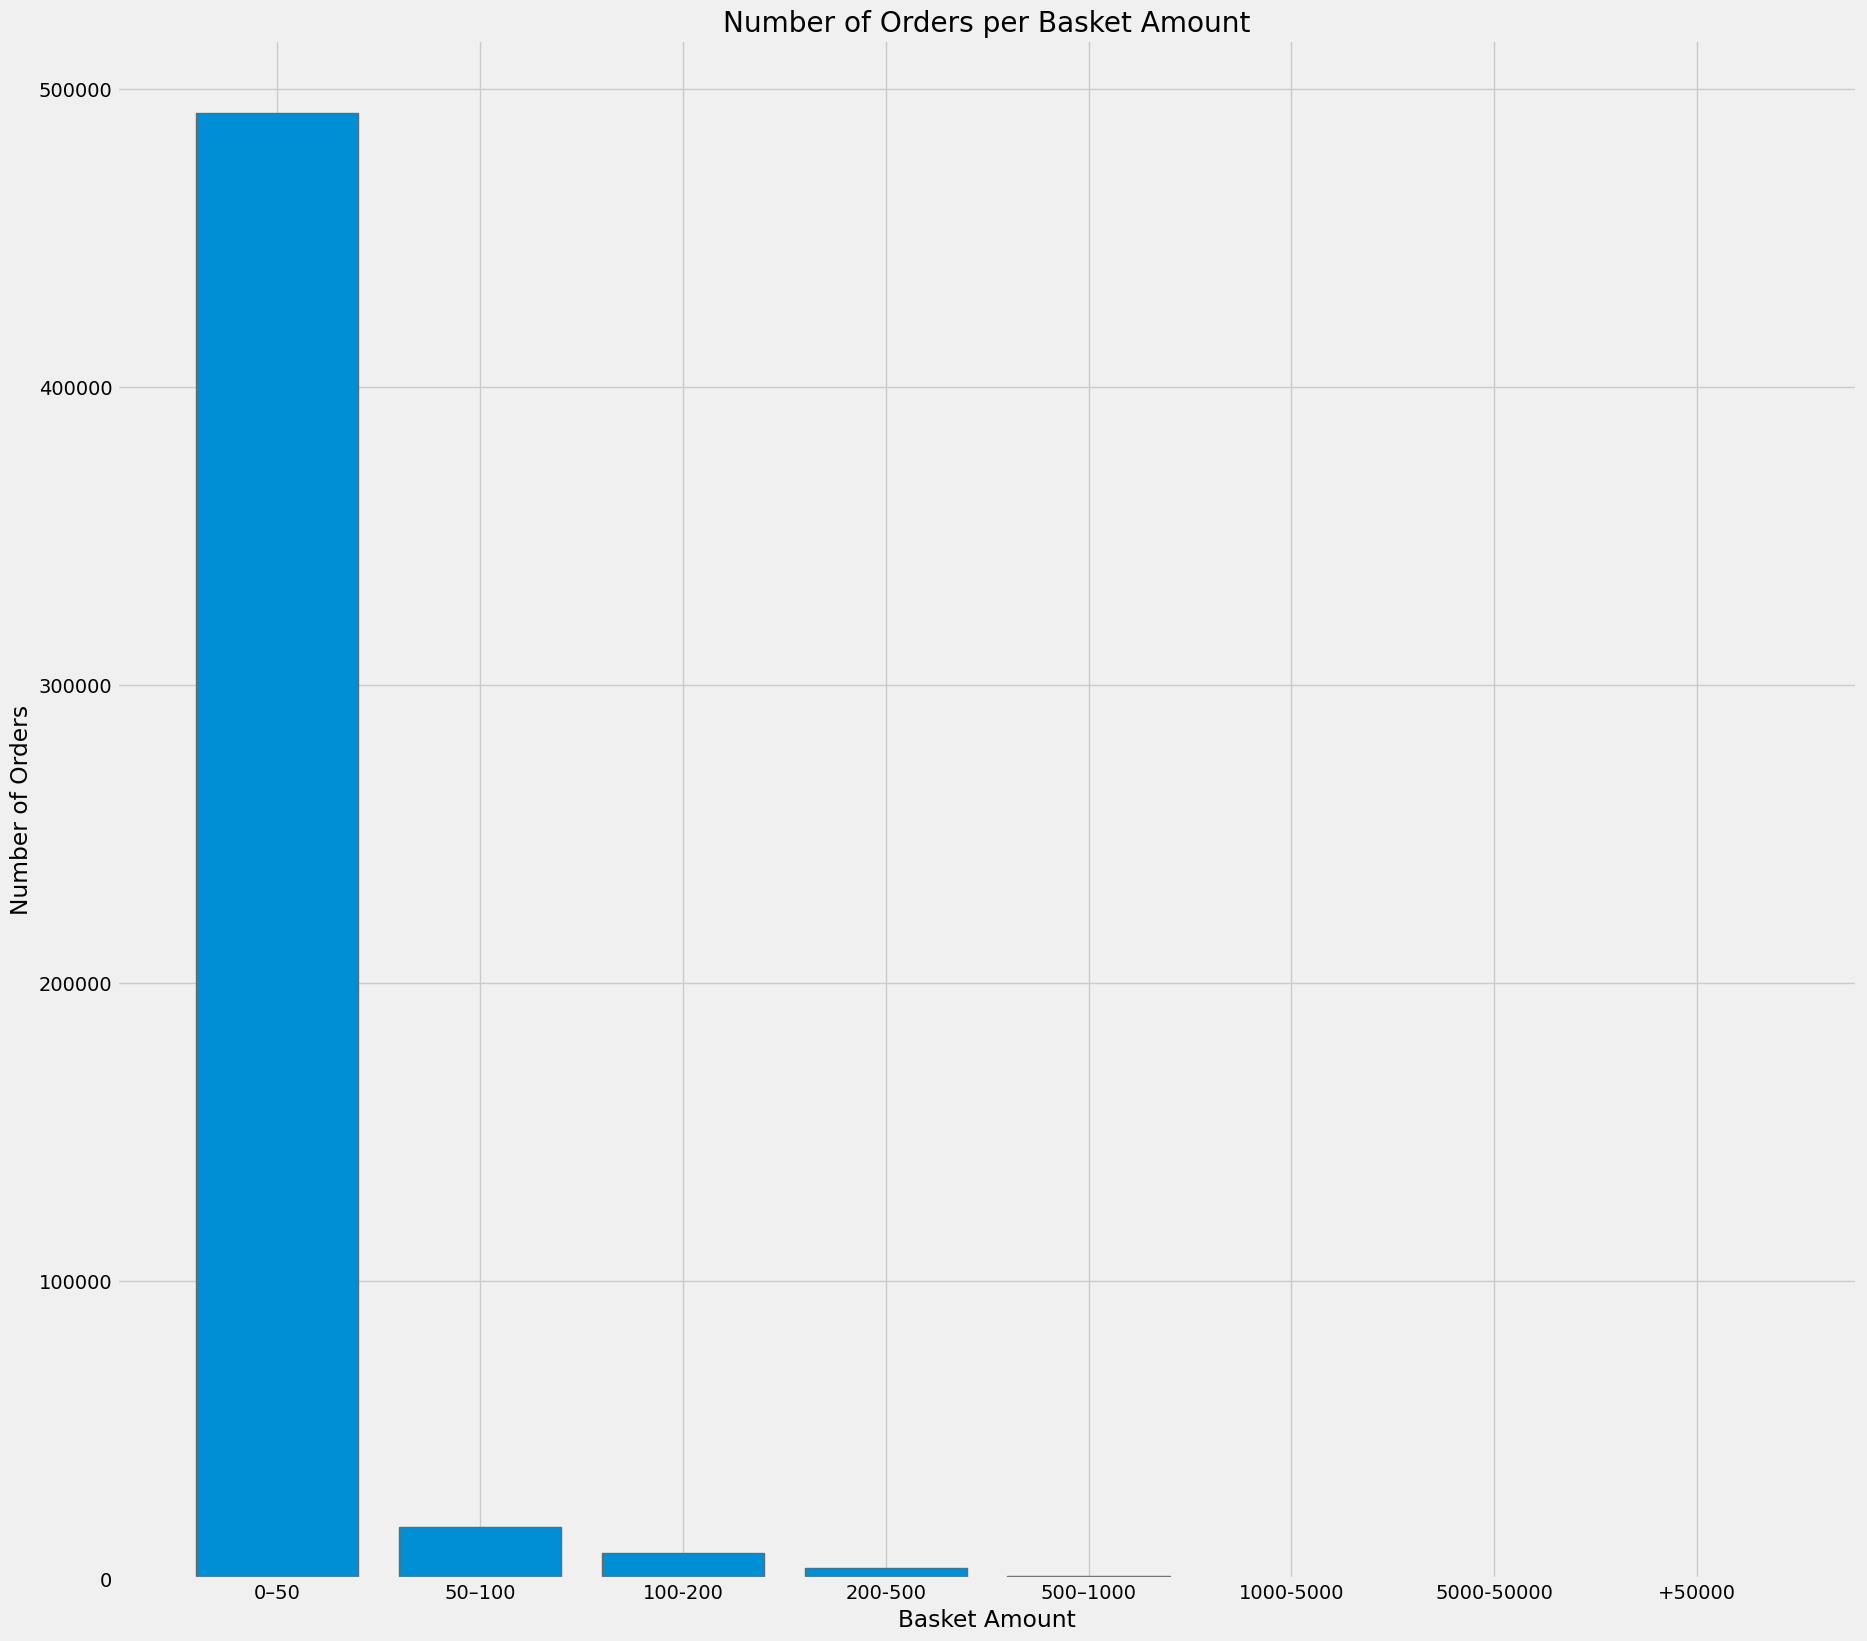

In [ ]:
# Define bins (ranges) and labels
bins = [0, 50, 100, 200, 500, 1000, 5000, 50000, float('inf')]
labels = ['0–50', '50–100', '100-200', '200-500', '500–1000', '1000-5000','5000-50000', '+50000']

# Create a new column with the basket amount category
df_cleaned['basket_amount'] = pd.cut(df_cleaned['TotalPrice'], bins=bins, labels=labels, right=True)

# number of orders per basket amount
temp = df_cleaned.groupby('basket_amount')['InvoiceNo'].count().reset_index(name='num_orders')
#display(temp)

# --------------------- Visualization -----------------------------
plt.figure(figsize=(20,19))
plt.bar(temp['basket_amount'], temp['num_orders'])
plt.xlabel('Basket Amount')
plt.ylabel('Number of Orders')
plt.title('Number of Orders per Basket Amount')
plt.show()

It can be seen that the majority of the transactions are small baskets (under 50).



---


## 3. Product Embeddings & Clustering

In [ ]:
len(df_cleaned['Description'].unique())

4078

The whole dataset has more than 4000 description for products, which is not easy to handle. I will instead make categories for these products. To do so, I will use embeddings since they can capture complex semantics in the descriptions.

In [ ]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Unique descriptions from the dataframe
descs = df_cleaned['Description'].unique()

# Embeddings using the loaded model
embeddings = model.encode(descs, batch_size=128, show_progress_bar=True)

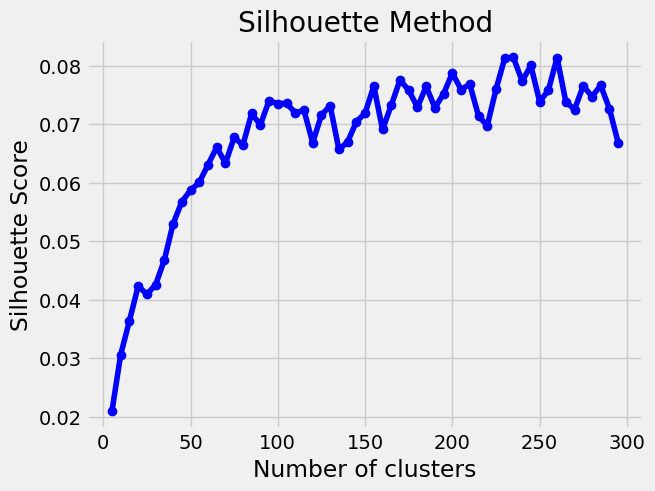

In [ ]:
scores = []
for k in range(5, 300, 5):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    scores.append(score)

plt.plot(range(5, 300, 5), scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

The graph shows that the silouhette score gets worse after 300ish. So, I will chose the number of clusters below that. And the score doesn't improve very much, so I will choose a number that is manageable and has a good score.

**P.S**: I have chosen 4 clusters since below in the visualization it showcased a better separation.

In [ ]:
# Cluster
n_clusters = 4  # tune based on diversity
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42).fit(embeddings)

# Map cluster to category
desc_to_cluster = dict(zip(descs, kmeans.labels_))
df_cleaned['category'] = df_cleaned['Description'].map(desc_to_cluster)

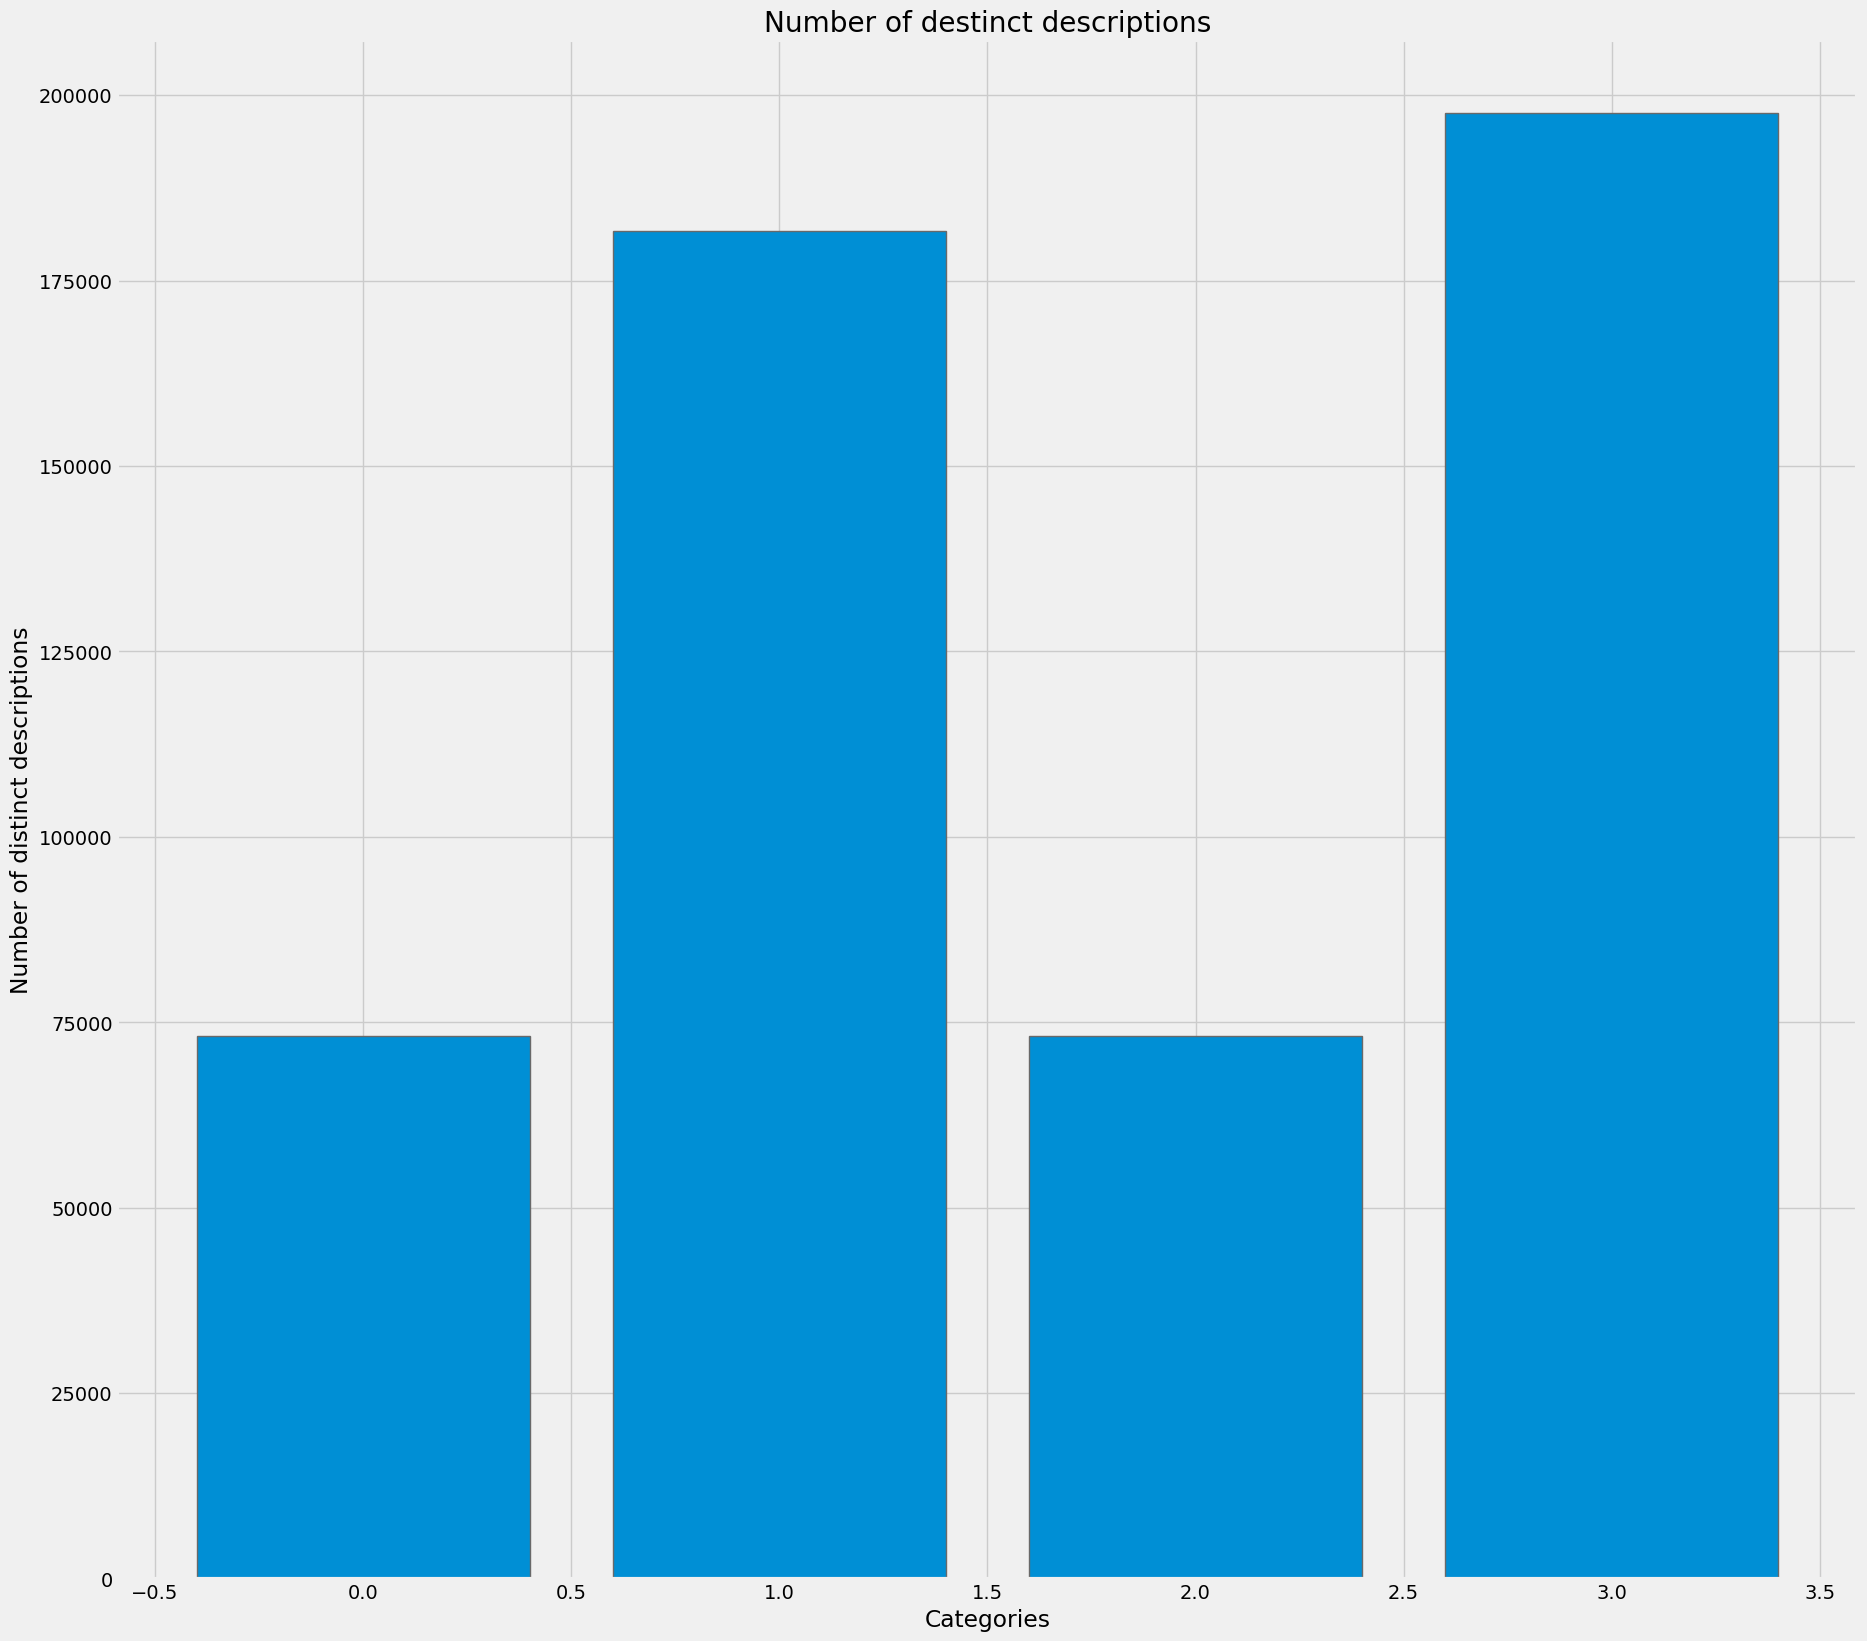

In [ ]:
desc_per_cluster = df_cleaned.groupby(by=['category'])['Description'].count().reset_index(name='numb_desc')

plt.figure(figsize=(20,19))
plt.bar(desc_per_cluster['category'], desc_per_cluster['numb_desc'])
plt.xlabel('Categories')
plt.ylabel('Number of distinct descriptions')
plt.title('Number of destinct descriptions')
plt.show()

Silhouette score (k=50): 0.021


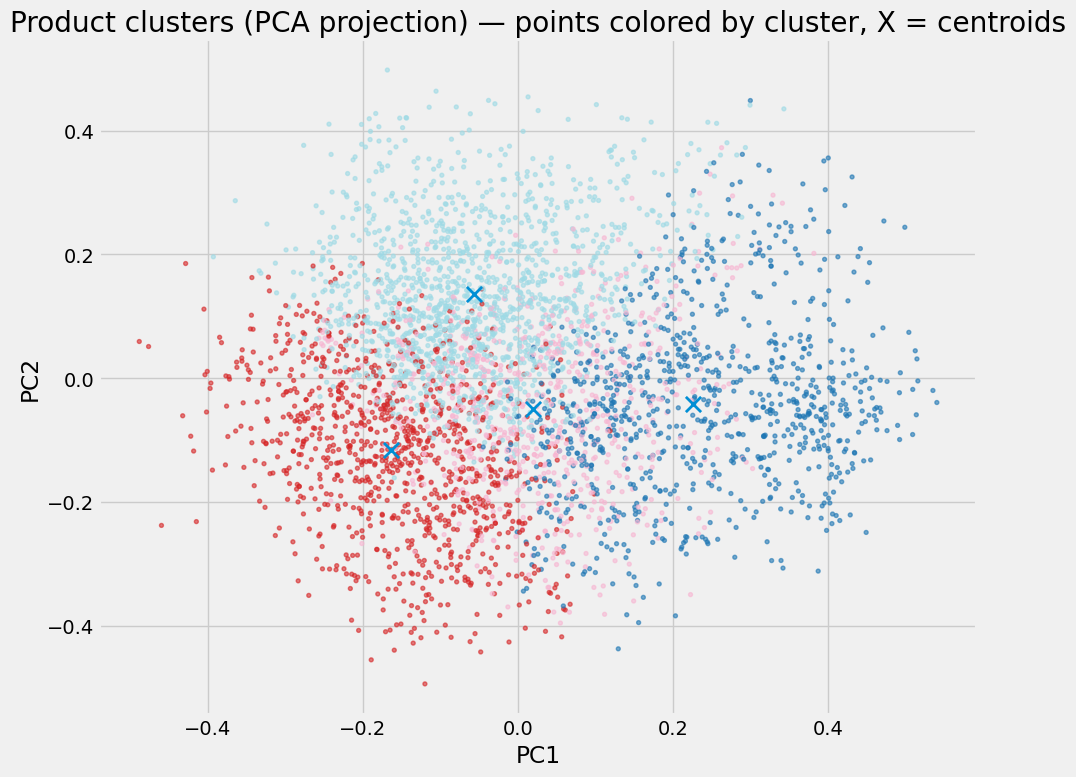

In [ ]:
# PCA to reduce the dimensions of embeddings
pca = PCA(n_components=2, random_state=42)
emb2d = pca.fit_transform(embeddings)               # embeddings: same array you fit kmeans on

df_emb = pd.DataFrame({
    'Description': descs,                            # one desc per row in `embeddings`
    'PC1': emb2d[:, 0],
    'PC2': emb2d[:, 1],
    'cluster': kmeans.labels_
})

# Silouhette score
try:
    sil = silhouette_score(embeddings, kmeans.labels_)
    print(f"Silhouette score (k=50): {sil:.3f}")
except Exception as e:
    print("Silhouette score not computed:", e)

# Project KMeans centroids into the same PCA space ---
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Subsample points for plotting clarity ---
MAX_POINTS = 20000
if len(df_emb) > MAX_POINTS:
    plot_df = df_emb.sample(n=MAX_POINTS, random_state=42)
else:
    plot_df = df_emb

# Plotting
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    plot_df['PC1'], plot_df['PC2'],
    c=plot_df['cluster'], s=8, alpha=0.6, cmap='tab20'
)
plt.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    marker='x', s=120, linewidths=2, edgecolors='k'
)
plt.title('Product clusters (PCA projection) — points colored by cluster, X = centroids')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.tight_layout()
plt.show()


In [ ]:
vectorizer = CountVectorizer(stop_words='english')

for c in sorted(df_cleaned['category'].unique()):
    texts = df_cleaned[df_cleaned['category'] == c]['Description'].astype(str)
    X = vectorizer.fit_transform(texts)
    word_freq = X.sum(axis=0).A1
    words = pd.Series(word_freq, index=vectorizer.get_feature_names_out())
    top_words = words.sort_values(ascending=False).head(10)
    print(f"\nCluster {c}: {', '.join(top_words.index)}")



Cluster 0: metal, heart, sign, light, holder, hanging, blue, white, glass, decoration

Cluster 1: set, bag, red, lunch, design, cake, retrospot, vintage, pink, box

Cluster 2: set, rose, red, pink, candles, candle, garden, flower, tea, retrospot

Cluster 3: bag, christmas, set, heart, vintage, retrospot, card, jumbo, red, design


I can see that some words do repeat in multiple clusters (from the visualization and the cluster words), since the products are very diverse and have long descriptions which sometimes don't necessarily reflect on the function of the product.

**Next step**: In real life, it would be easier to get the different categories that the company classifies its products into and can be tested and used in this part of this sort project. Unfortunately, in this case we do not have this info.

___
## 4. Customer Feature Engineering


*a. Grouping products*



In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 9]$) that contains the amount spent in each product category:

In [ ]:
for i in range(10):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['category'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'category', 'categ_0', 'categ_1', 'categ_2', 'categ_3']][:5]

,InvoiceNo,Description,category,categ_0,categ_1,categ_2,categ_3
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.30,0.0,0.00,0.00
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.00,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.00,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.00,0.0,20.34,0.00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.00,0.0,0.00,20.34


to summarize data, I create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 10 categories of products:

In [ ]:
#___________________________________________
# Total price
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# The price per order category
for i in range(4):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    # Merge the temporary DataFrame with basket_price
    basket_price = pd.merge(basket_price, temp, on=['CustomerID', 'InvoiceNo'], how='left')

#_____________________
# Order's date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# significant entries
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,InvoiceDate
5,12347.0,562032,584.91,127.8,167.55,30.56,259.00,2011-08-02 08:48:00
3,12347.0,549222,636.25,32.7,430.55,49.20,123.80,2011-04-07 10:43:00
6,12347.0,573511,1294.32,105.0,536.08,234.02,419.22,2011-10-31 12:25:00
7,12347.0,581180,224.82,17.4,12.48,73.28,121.66,2011-12-07 15:52:00
4,12347.0,556201,382.52,30.0,112.00,103.26,137.26,2011-06-09 13:01:00


*b. Separation of data over time*



The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
set_entrainement = basket_price[basket_price['InvoiceDate'].dt.date < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'].dt.date >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

*c. Consumer Order Combinations*

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:
# Number of visits and stats of the basket amount /users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(4):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3
0,12347.0,5,382.52,711.79,558.172000,2790.86,20.367915,43.355811,9.438668,26.837606
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,45.091362,0.000000,54.908638
2,12350.0,1,334.40,334.40,334.400000,334.40,30.053828,32.505981,5.921053,31.519139
3,12352.0,6,144.35,840.30,345.663333,2073.98,2.054022,30.013790,8.753701,59.178488
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,100.000000,0.000000,0.000000


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,20.367915,43.355811,9.438668,26.837606,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,45.091362,0.000000,54.908638,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,30.053828,32.505981,5.921053,31.519139,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,2.054022,30.013790,8.753701,59.178488,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,100.000000,0.000000,0.000000,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1445/3608  (40.05%)


*e. Creation of customers categories*


The dataframe `transactions_per_user` contains a summary of all the orders that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  14.15954176
  35.67261258  14.81368228  35.36301299]


At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained with 7 clusters:

In [ ]:
silhouette_scores = []

for n_clusters in range(2, 30, 1):
  kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
  kmeans.fit(scaled_matrix)
  clusters_clients = kmeans.predict(scaled_matrix)
  silhouette_scores.append(silhouette_score(scaled_matrix, clusters_clients))

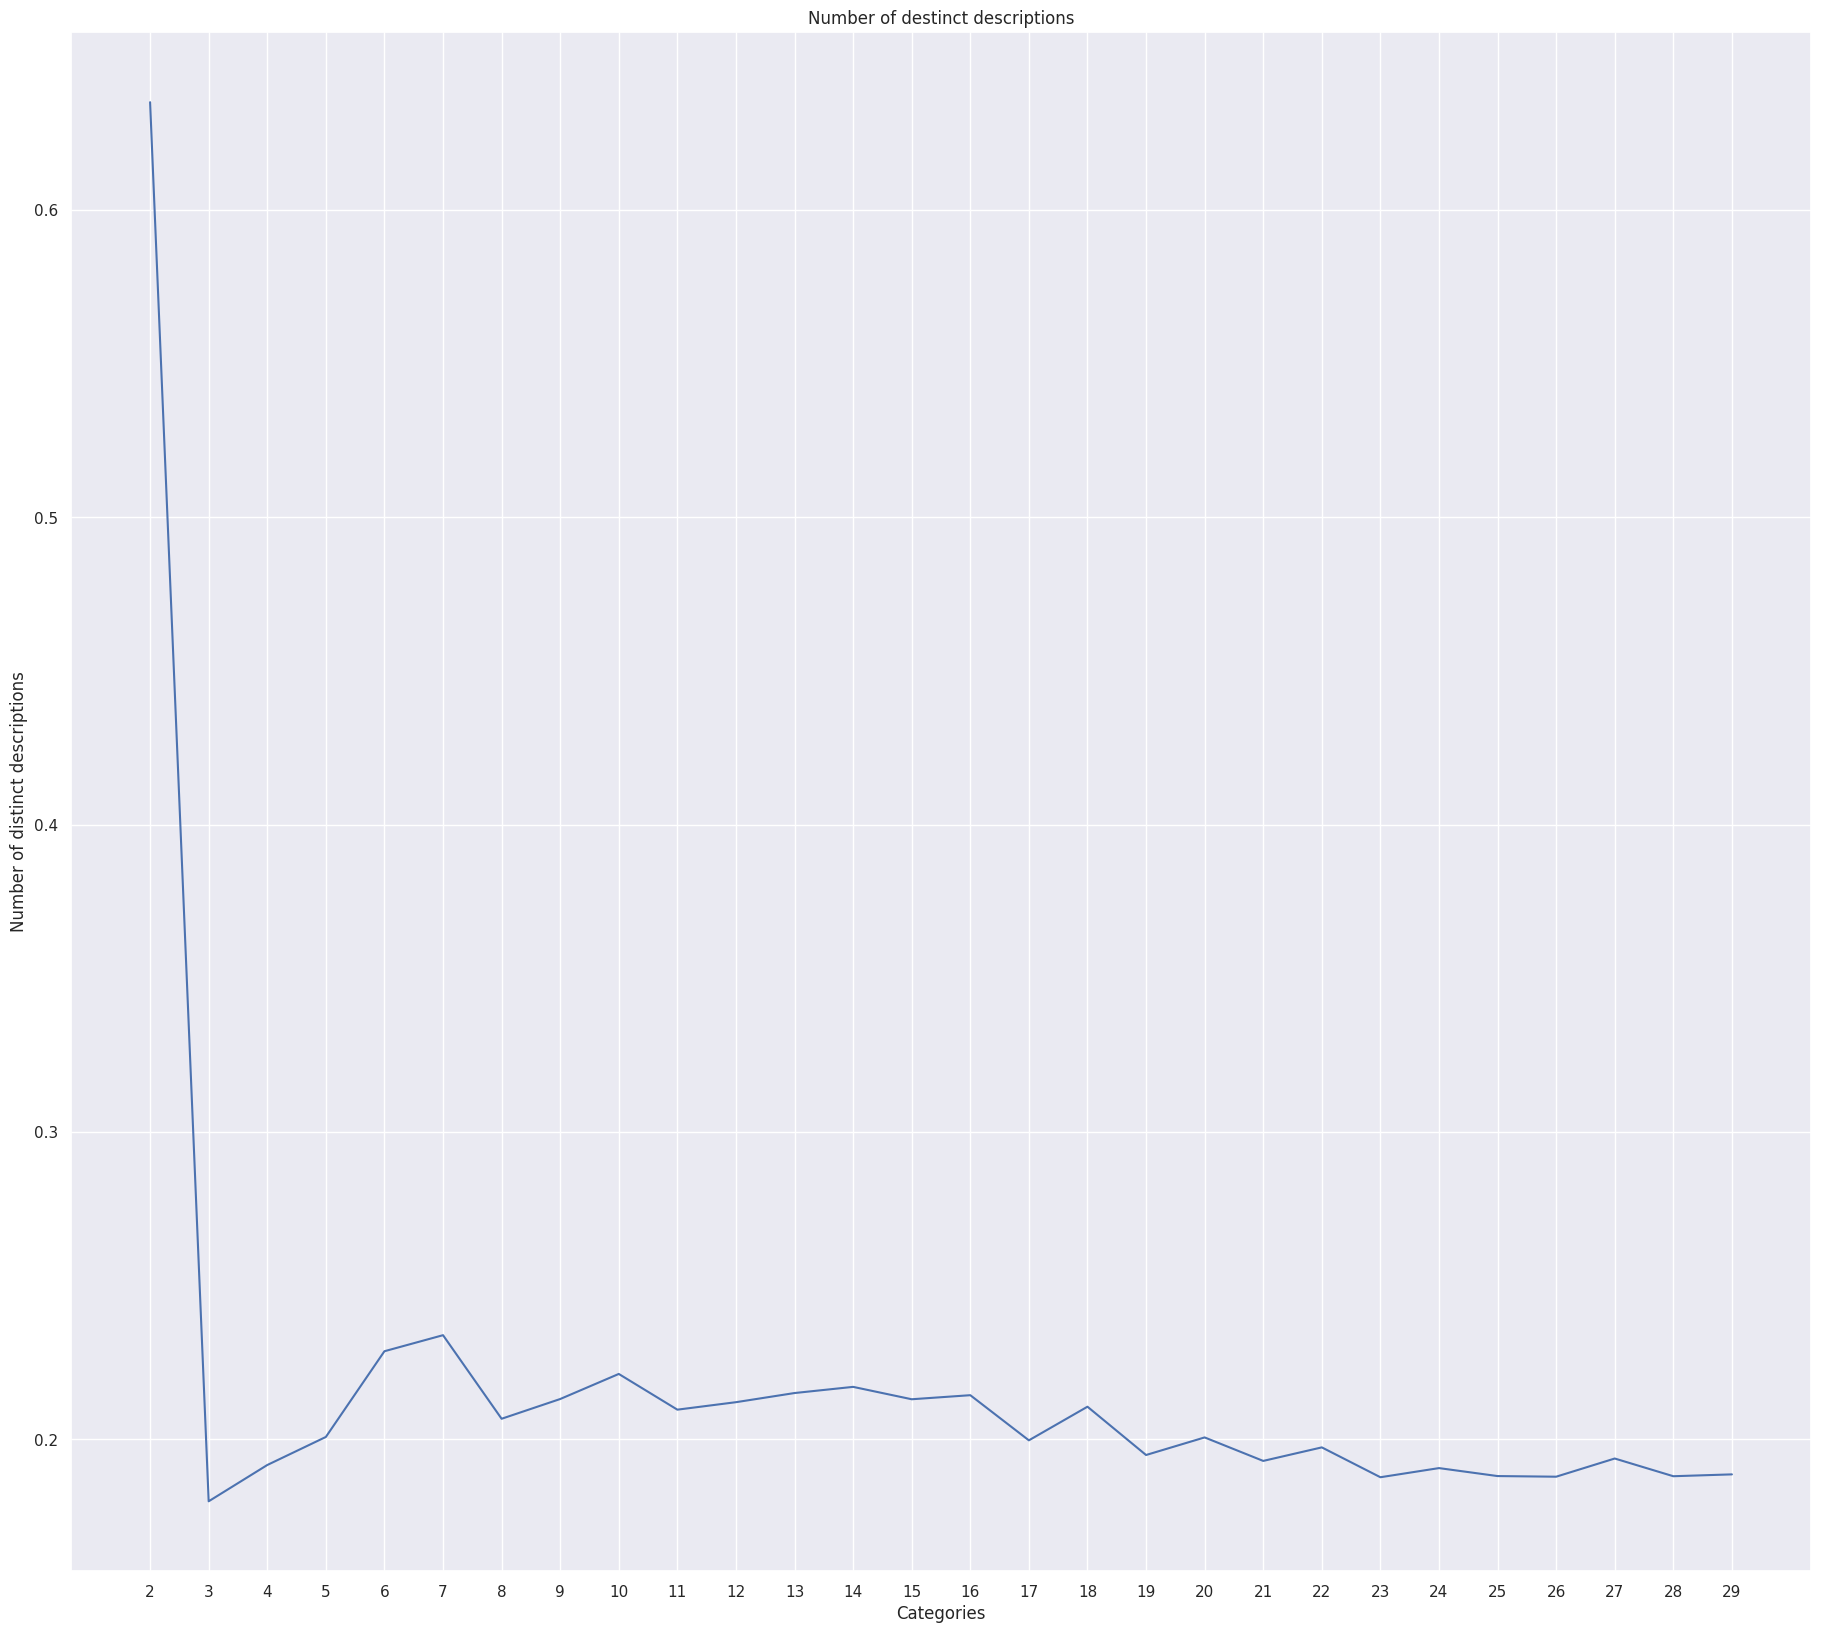

In [ ]:
plt.figure(figsize=(20,19))
plt.plot([ str(n) for n in range(2, 30, 1)], silhouette_scores)
plt.xlabel('Categories')
plt.ylabel('Number of distinct descriptions')
plt.title('Number of destinct descriptions')
plt.show()

2 is ideally the number of clusters for the customers of this company according to the available data. This however depends on the business needs and regulations.

On the other hand, we need more clusters to know which clients we need to focus on. So I will choose 7 since it has a higher silhouette score comparing to the rest.

In [ ]:
n_clusters = 7
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.234


At first, I look at the number of customers in each cluster:

In [ ]:
counts = np.bincount(clusters_clients, minlength=n_clusters)
counts_df = pd.DataFrame({
    'cluster': np.arange(n_clusters),
    'n_customers': counts
})
counts_df

,cluster,n_customers
0,0,406
1,1,113
2,2,1255
3,3,1428
4,4,376
5,5,23
6,6,7


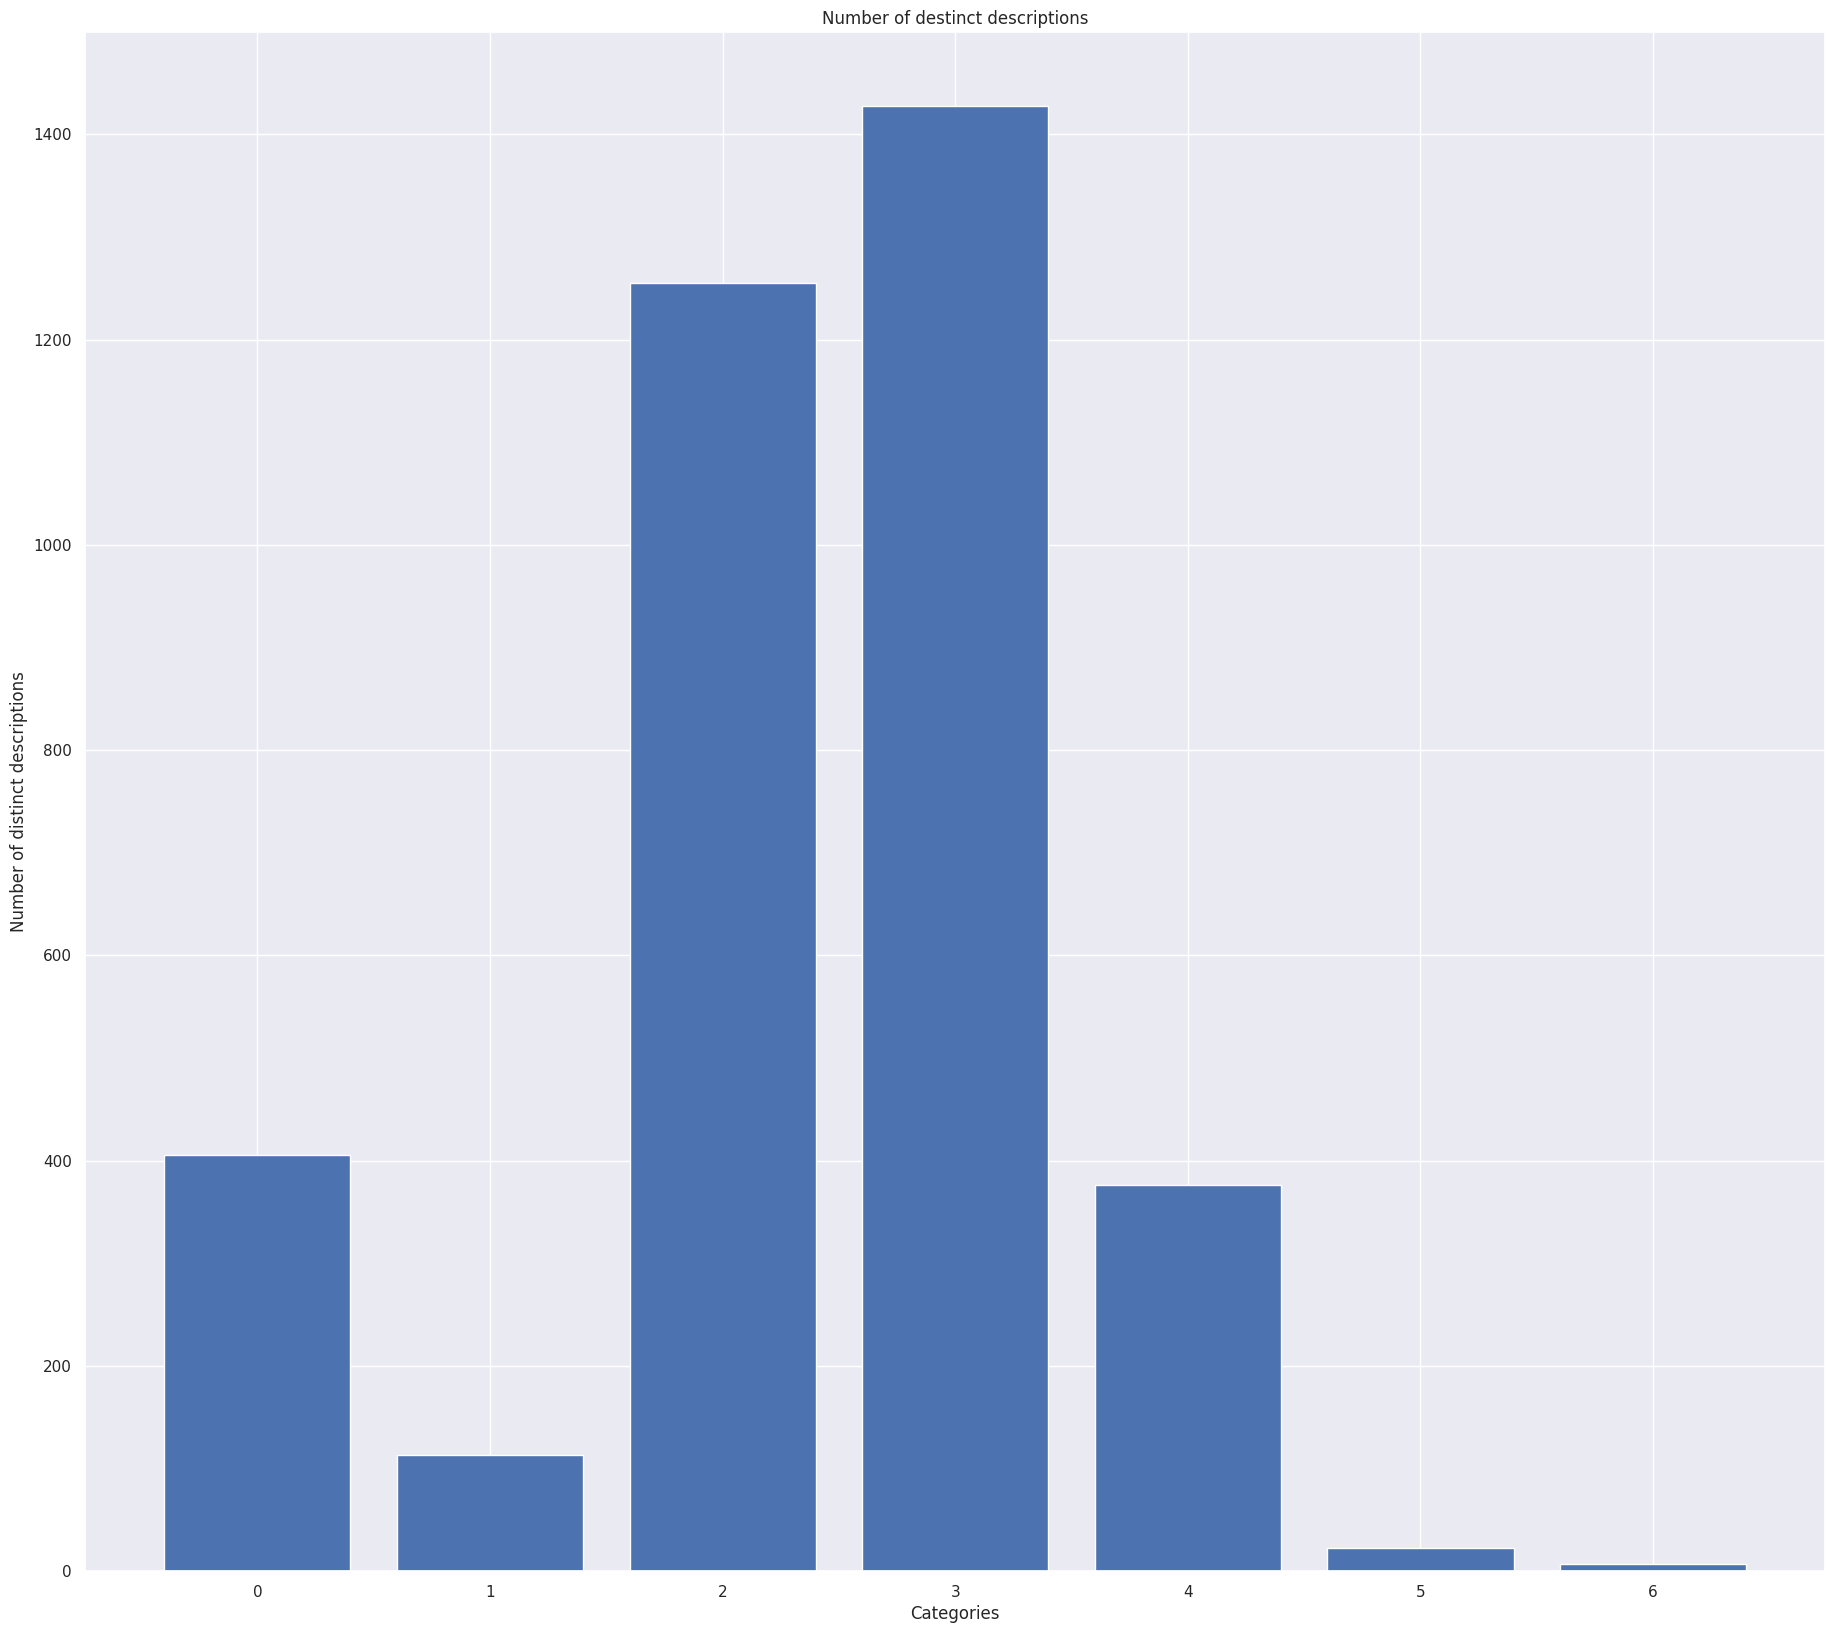

In [ ]:
plt.figure(figsize=(20,19))
plt.bar(counts_df['cluster'], counts_df['n_customers'])
plt.xlabel('Categories')
plt.ylabel('Number of distinct descriptions')
plt.title('Number of destinct descriptions')
plt.show()

*f. Report via the PCA*



There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

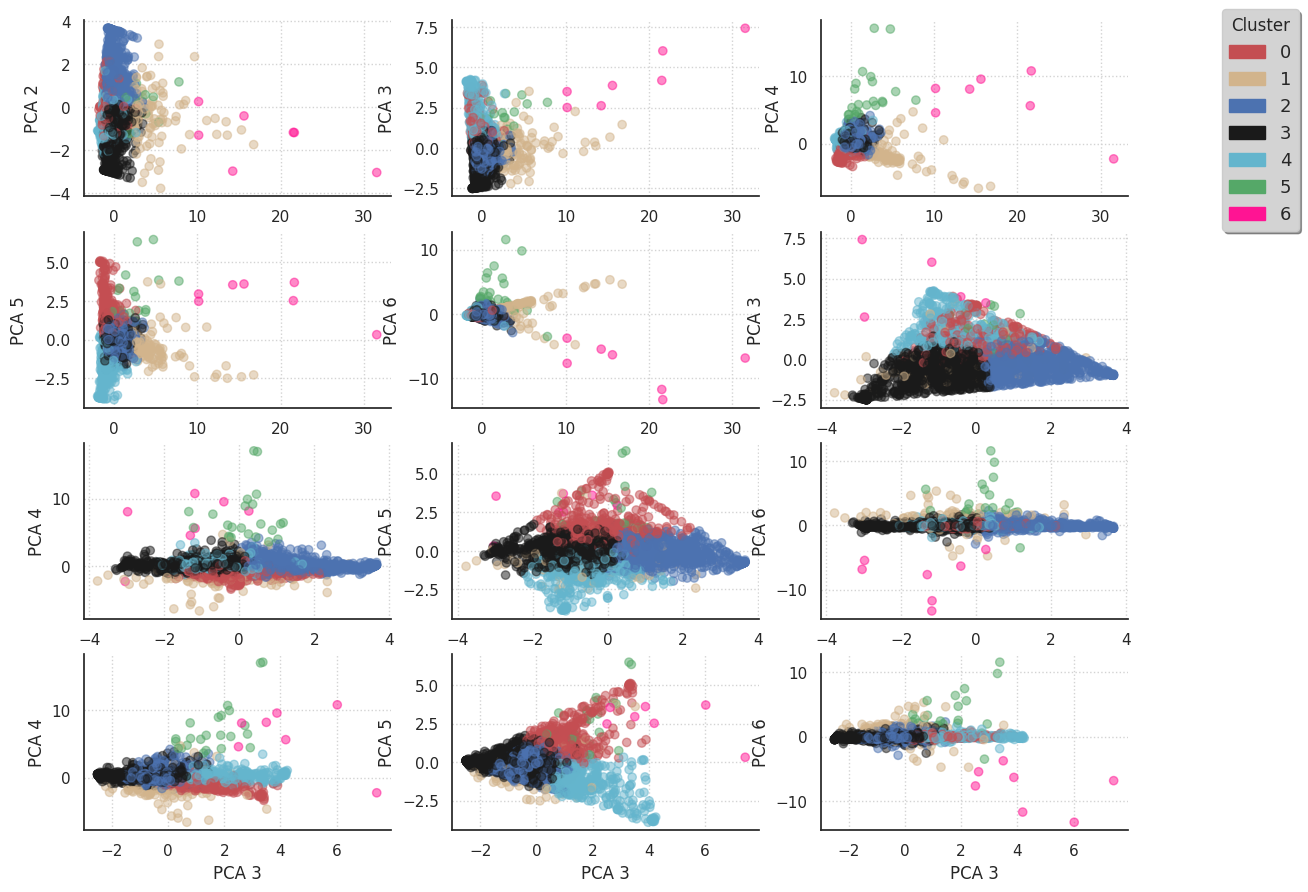

In [ ]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

*g. Customers morphotype*

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [ ]:
merged_df = pd.DataFrame()
for i in range(5):
    col = 'categ_{}'.format(i)
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3578


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [ ]:
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,size
0,0.0,2.172414,196.683300,301.102761,243.695564,589.560569,9.955928,22.785303,42.866849,24.419695,406
1,4.0,2.827128,192.609814,357.895798,261.824115,821.713989,50.890686,17.844634,10.659400,20.613796,376
2,3.0,3.222689,237.197971,468.841611,338.715214,1151.765239,11.486551,24.703107,11.423727,52.392366,1428
3,2.0,3.837450,218.659442,497.774040,337.393075,1412.154685,8.058133,57.175704,10.942975,23.830235,1255
4,1.0,2.185841,1488.949115,2243.574345,1813.142140,4502.035496,8.088478,40.984856,13.687140,37.240123,113


*h. Customers morphology*

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

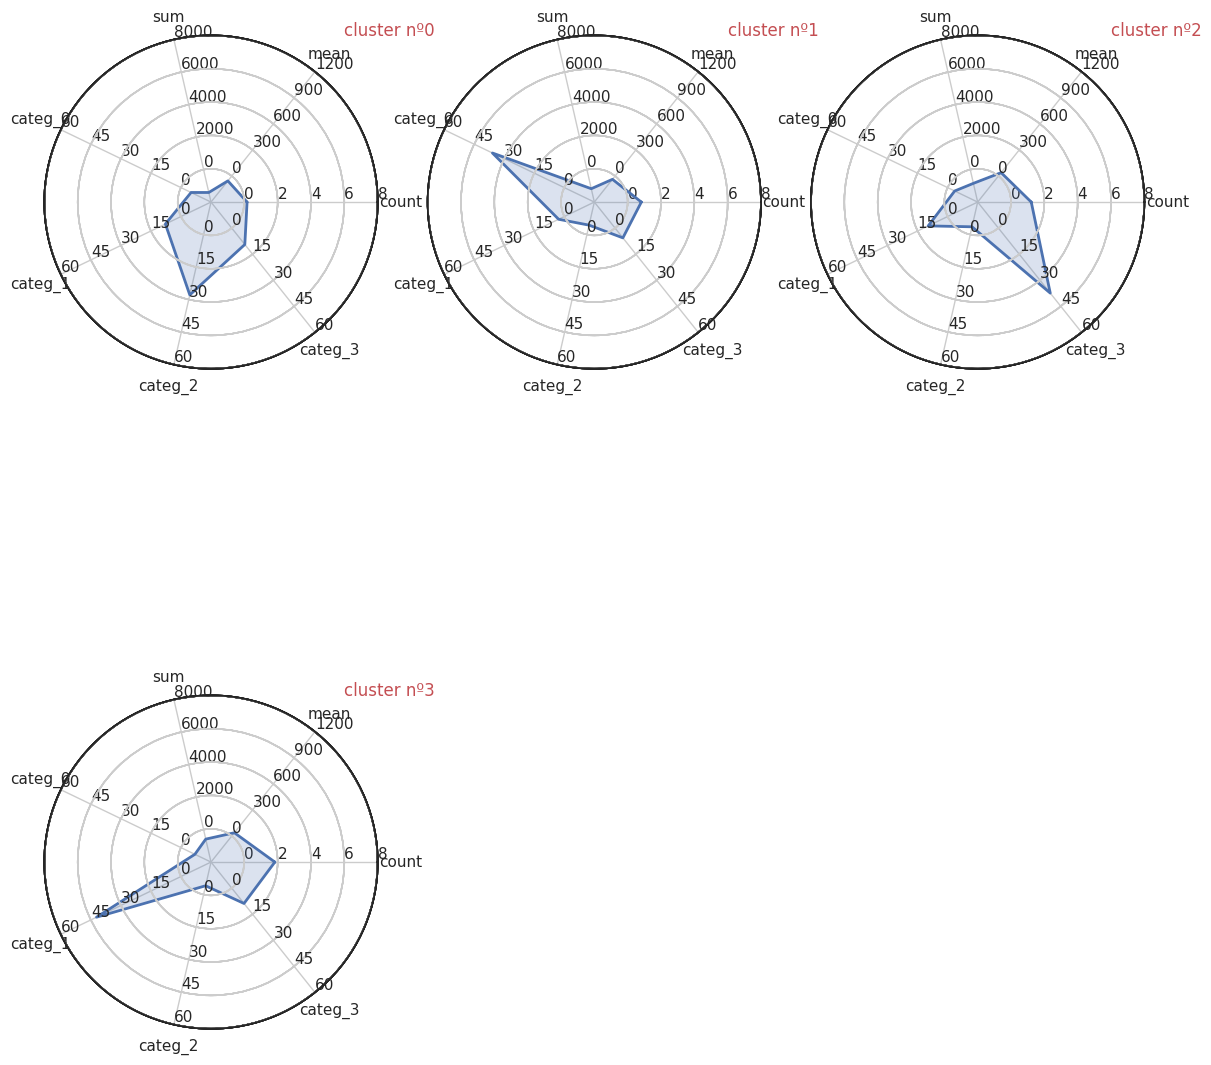

In [ ]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(4):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y]
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

It can be seen, for example, that the 4 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).


____
## 5. Customer Segmentation

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers:

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))


Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3']
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I split the dataset in train and test sets:

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [ ]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [ ]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data:

In [ ]:
svc.grid_predict(X_test, Y_test)

Precision: 92.38 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


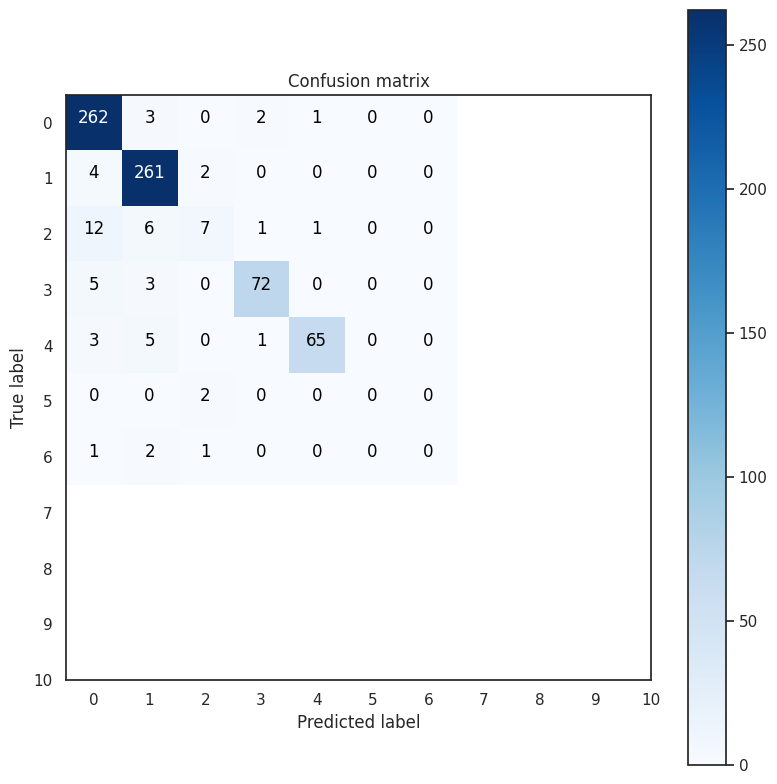

In [ ]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

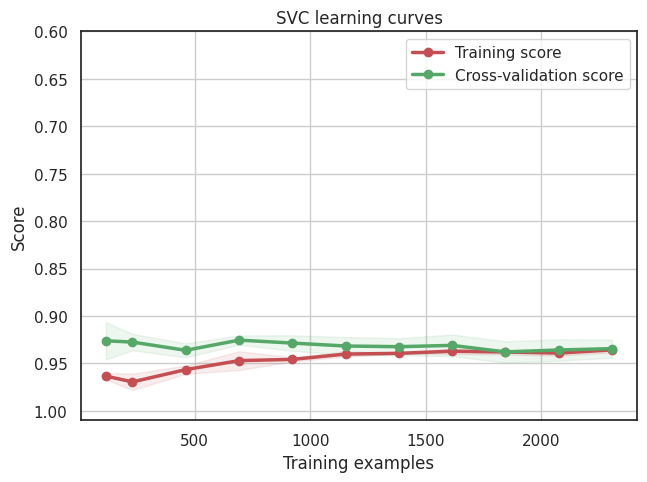

In [ ]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.


___
### 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 94.32 % 


Then, I plot the learning curve to have a feeling of the quality of the model:

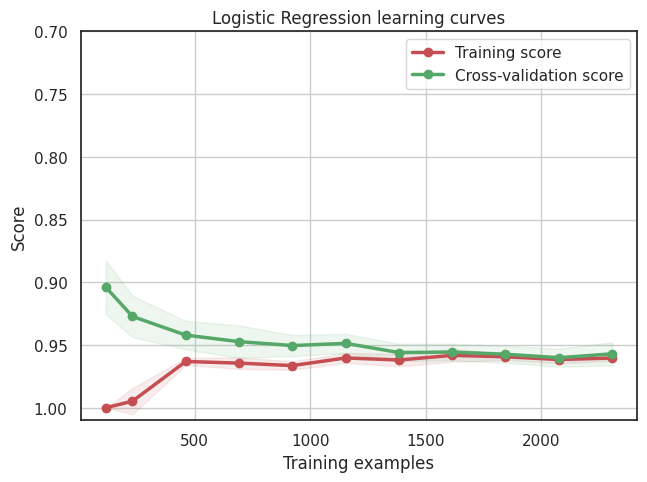

In [ ]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 88.23 % 


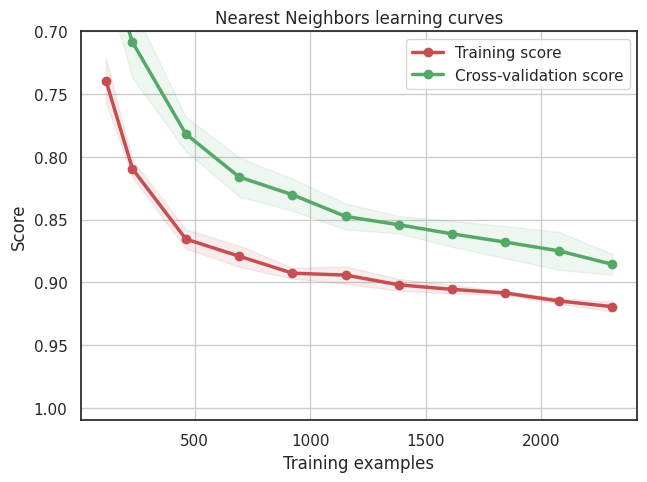

In [ ]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 92.80 % 


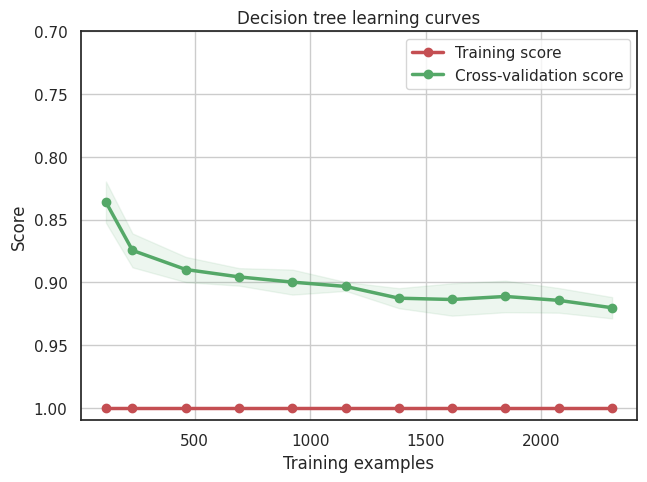

In [ ]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 95.57 % 


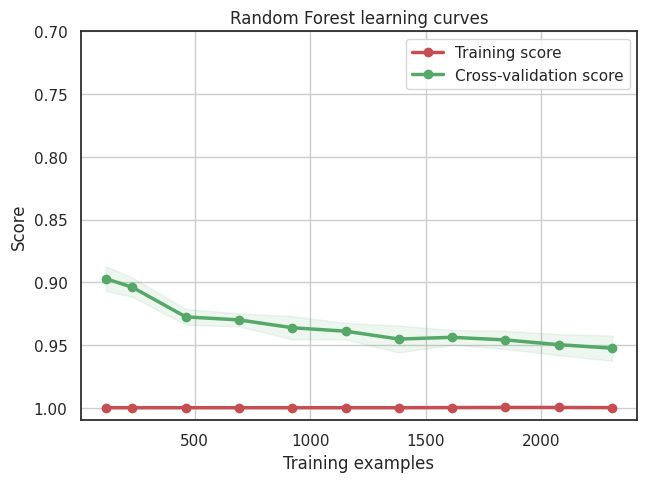

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [ ]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 89.34 % 


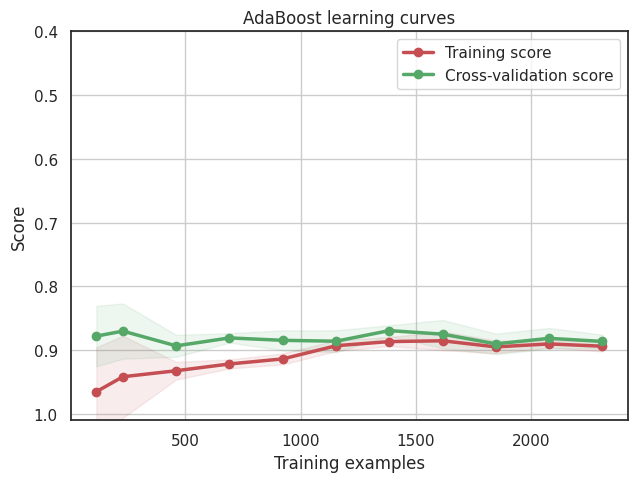

In [ ]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [ ]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 94.74 % 


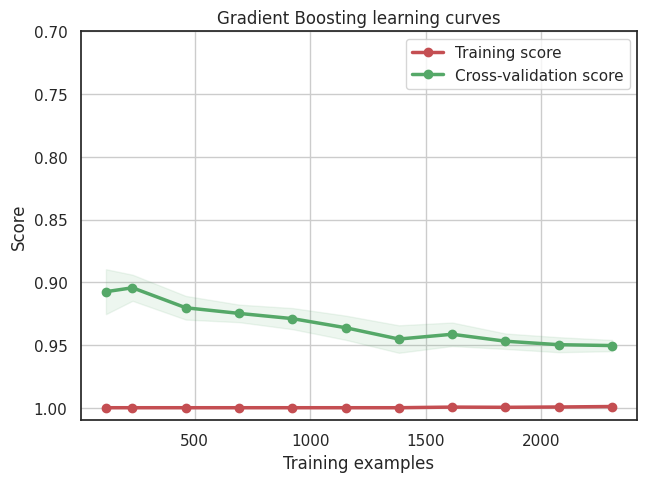

In [ ]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### 5.8 Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [ ]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [ ]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')

and train it:

In [ ]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [ ]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 94.60 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [ ]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(4):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3
0,12347.0,10,224.82,1294.32,759.57,7595.70,8.057190,36.109904,20.228550,35.604355
1,12349.0,5,1757.55,1757.55,1757.55,8787.75,8.102757,36.657848,19.223351,36.016045
2,12352.0,5,311.73,311.73,311.73,1558.65,15.750810,43.178392,0.000000,41.070798
3,12356.0,5,58.35,58.35,58.35,291.75,0.000000,43.701799,56.298201,0.000000
4,12357.0,5,6207.67,6207.67,6207.67,31038.35,6.445897,41.110755,23.923630,28.519718


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [ ]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3']
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [ ]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 89.34 % 
______________________________ 
Logostic Regression
Precision: 90.94 % 
______________________________ 
k-Nearest Neighbors
Precision: 85.85 % 
______________________________ 
Decision Tree
Precision: 87.69 % 
______________________________ 
Random Forest
Precision: 91.06 % 
______________________________ 
Gradient Boosting
Precision: 90.16 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [ ]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 91.42 % 


___
## 7. Conclusion


In this project, the objective was to understand customer behavior through data-driven segmentation.  
By combining **text embeddings** for product descriptions and **clustering algorithms**, we were able to group similar products and identify distinct customer profiles based on their purchase patterns.

The results revealed a few interesting insights:
- Customers can be roughly segmented into groups such as **frequent low-spenders**, **seasonal high-value buyers**, and **occasional bargain seekers**.
- Product embeddings helped uncover **latent relationships** between items that traditional category labels didn’t capture.
- Customer clusters show clear differences in **average spend**, **basket diversity**, and **purchase frequency**.

From a business perspective, these segments could help drive:
- More personalized marketing campaigns.  
- Targeted product recommendations.  
- Better inventory and promotion planning.

However, there are still areas for improvement. The dataset is limited to a specific period and lacks demographic information.  
Future work could explore **dynamic segmentation over time**, **customer lifetime value prediction**, and **deep learning approaches** (e.g., transformers or autoencoders) for more robust embeddings.

Overall, this project demonstrates how combining **unsupervised learning** and **text representation techniques** can yield valuable, interpretable insights about customer behavior.
